# Factorization Machines
### Load Packages

In [93]:
#packages
import pandas as pd
import numpy as np
import implicit as im
from scipy.sparse import csr_matrix
from scipy.sparse import coo_matrix
import random
import ast
import math
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from lightfm import LightFM
from lightfm.datasets import fetch_movielens
from lightfm.evaluation import precision_at_k

### Load Data

In [238]:
#read data
proc_dir = "../data/processed"

customers = pd.read_csv(proc_dir+"/customers.csv")
customers = customers['user']
games = pd.read_csv(proc_dir+"/games.csv")
games = games['game']
genres = pd.read_csv(proc_dir+"/genres.csv")
genres = genres['genre']
hours = pd.read_csv(proc_dir+"/hours.csv")
hours = hours[['userIndex', 'gameID', 'hours']]
games_info = pd.read_csv(proc_dir+"/gameInfo.csv")
games_info = games_info[['genres', 'popularity','rating']]
game_genres = games_info['genres'].apply(ast.literal_eval)
game_popularity = games_info['popularity']
game_rating = games_info['rating']
#make genres easier for features
n_genres = [i for i,x in enumerate(genres) if x != 'N\A']

In [3]:
print 'Sample game:', games[0]
print 'Genres:', genres[game_genres[0]]
print 'Popularity:', game_popularity[0]
print 'User Rating:', game_rating[0]

Sample game: The Elder Scrolls V Skyrim
Genres: 12    Role-playing (RPG)
13             Simulator
15              Strategy
31             Adventure
32                 Indie
Name: genre, dtype: object
Popularity: 97.6666666667
User Rating: 80.0


### Clean Data
No side information was given for this dataset so we got creative and used the IGDb (Internet Game Database) to search for side information.  We used 2 techniques to get the best results: 1) by the game name for a match, 2) if no match was found, we used a more flexible string search to find a match.  This proved very efficient on a small sample size.  Only 150 game genres and popularity ratings were not found so we will remove those from our dataset (both were the same game set) so we now have side information on all games.  We only lost 2.4% of user interactions, but in the real world we could easily update side information for the games we removed.  This keeps our dataset clean.

In [4]:
#remove genres
bad_games=[i for i, j in enumerate(game_genres) if j == -1]
#update popularity to 1 as not popular since not found 
bad_pops=[i for i, j in enumerate(game_popularity) if j == -1]
if(bad_games==bad_pops):
    print 'games missing genres are the same missing popularity ratings'

#remove from ratings
good_games=[i for i, j in enumerate(game_genres) if j != -1]
print 'Of', len(hours), 'interactions we lose', len(hours[hours.gameID.isin(bad_games)])
ratings = hours[hours.gameID.isin(good_games)]
print 'Our new ratings:', len(ratings)

games missing genres are the same missing popularity ratings
Of 70489 interactions we lose 1700
Our new ratings: 68789


### Normalizing the data
One thing we noticed from part one of the project was the hours played was not a good rating due to the large difference among users which caused biases.  To prevent this, we will normalize the data but in a scaled way to take into consideration the exponential decay distribution as shown in the histogram plots.

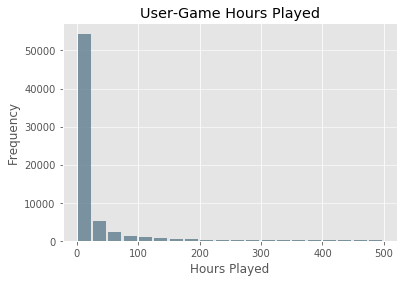

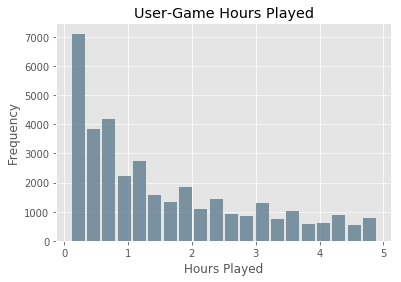

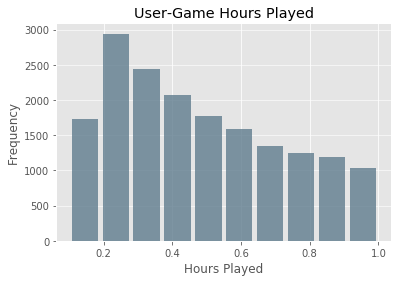

In [5]:
#plot histogram of ratings
plt.hist(x=ratings.hours[ratings.hours < 500], bins=20, color='#607c8e',
                            alpha=0.8, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Hours Played')
plt.ylabel('Frequency')
plt.title('User-Game Hours Played')
plt.show()
plt.hist(x=ratings.hours[ratings.hours < 5], bins=20, color='#607c8e',
                            alpha=0.8, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Hours Played')
plt.ylabel('Frequency')
plt.title('User-Game Hours Played')
plt.show()
plt.hist(x=ratings.hours[ratings.hours <= 1], bins=10, color='#607c8e',
                            alpha=0.8, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Hours Played')
plt.ylabel('Frequency')
plt.title('User-Game Hours Played')
plt.show()

In [10]:
#create new dataframe
#ratings_df= pd.DataFrame(columns=['userIndex','gameID','rating'])
#for index, row in ratings.iterrows():
#    ratings_df = ratings_df.append({'userIndex':row['userIndex'],'gameID':row['gameID'],'rating':row['hours']}, ignore_index=True)
#ratings_df.to_csv(proc_dir+"/rel_ratings.csv")

#load related ratings
#ratings = pd.read_csv(proc_dir+"/rel_ratings.csv")
#ratings = ratings[['userIndex', 'gameID', 'rating']]

In [11]:
#[0,.1)=0, [.1,.5)=1, [.5,2)=2, [2,10)=3, [10,50)=4, [50+)=5
#for i, h in ratings.iterrows():
#    if(.1 <= h['rating'] < .5):
#        ratings.loc[i,'rating']=1
#    elif(.5 <= h['rating'] < 2):
#        ratings.loc[i,'rating']=2
#    elif(2 <= h['rating'] < 10):
#        ratings.loc[i,'rating']=3
#    elif(10 <= h['rating'] < 50):
#        ratings.loc[i,'rating']=4
#    elif(h['rating'] >= 50):
#        ratings.loc[i,'rating']=5
#    else:
#        print 'something went wrong'
#print 'done'
#ratings.to_csv(proc_dir+"/norm_ratings.csv")

done


In [14]:
#load ratings normalized
ratings = pd.read_csv(proc_dir+"/norm_ratings.csv")
ratings = ratings[['userIndex', 'gameID', 'rating']]

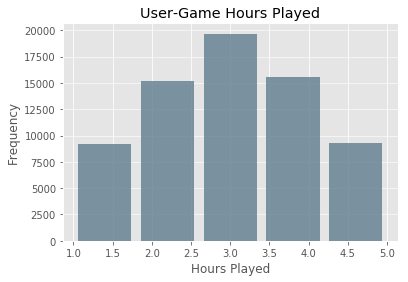

In [15]:
plt.hist(x=ratings.rating, bins=5, color='#607c8e',
                            alpha=0.8, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Hours Played')
plt.ylabel('Frequency')
plt.title('User-Game Hours Played')
plt.show()

### Functions for sampling train and test
While sampling data, we can get sparse data and dense data by going off the number of interactions by users

In [336]:
#only 1700 sparse users
def getSparseData(ratings, size=500, seed=43):
    #get users with low interactions > 2 but < 8
    usersGrouped = ratings.groupby('userIndex', as_index=False).agg({'rating':'count'})
    lessInteractions = usersGrouped[usersGrouped.rating < 8]
    sampleUsers = lessInteractions[lessInteractions.rating > 2]
    #now get your sample size
    random.seed(seed)
    randomSampleUsers = map(int, random.sample(sampleUsers.userIndex,size))
    #get items which these users interacted with
    itemsInteracted=ratings[ratings.userIndex.isin(randomSampleUsers)]
    sampleItems = map(int,itemsInteracted['gameID'].unique())
    return randomSampleUsers, sampleItems, itemsInteracted

#only 975 dense users
def getDenseData(ratings, size=500, seed=43):
    #get users with high interactions > 12 
    usersGrouped = ratings.groupby('userIndex', as_index=False).agg({'rating':'count'})
    moreInteractions = usersGrouped[usersGrouped.rating > 15]
    #now get your sample size
    random.seed(seed)
    randomSampleUsers = map(int, random.sample(moreInteractions.userIndex,size))
    #get items which these users interacted with
    itemsInteracted=ratings[ratings.userIndex.isin(randomSampleUsers)]
    sampleItems = map(int,itemsInteracted['gameID'].unique())
    return randomSampleUsers, sampleItems, itemsInteracted

#only 3400 good users
def getGoodData(ratings, size=500, seed=43):
    #get users with good interactions > 2 
    usersGrouped = ratings.groupby('userIndex', as_index=False).agg({'rating':'count'})
    moreInteractions = usersGrouped[usersGrouped.rating > 2]
    #now get your sample size
    random.seed(seed)
    randomSampleUsers = map(int, random.sample(moreInteractions.userIndex,size))
    #get items which these users interacted with
    itemsInteracted=ratings[ratings.userIndex.isin(randomSampleUsers)]
    sampleItems = map(int,itemsInteracted['gameID'].unique())
    return randomSampleUsers, sampleItems, itemsInteracted

def getTrainTestData(ratings, percent=.2, seed=43):
    random.seed(seed)
    testCount = int(len(ratings)*percent)
    testRows = random.sample(range(0,len(ratings)-1),testCount)
    trainRatings = pd.DataFrame(columns=['userIndex','gameID','rating'])
    testRatings = pd.DataFrame(columns=['userIndex','gameID','rating'])
    ind=0
    for index, row in ratings.iterrows():
        if(ind in testRows):
            testRatings = testRatings.append({'userIndex':row['userIndex'],
                                              'gameID':row['gameID'],
                                              'rating':row['rating']}, ignore_index=True)
        else:
            trainRatings = trainRatings.append({'userIndex':row['userIndex'],
                                                'gameID':row['gameID'],
                                                'rating':row['rating']}, ignore_index=True)
        ind=ind+1
    return trainRatings, testRatings

#top k correct
def correctRecommendations(users, items, model, matrix, testRatings, topK=10):
    recommended=0
    missed=0
    for index, row in testRatings.iterrows():
        topRecommends = column(model.recommend(users.index(row['userIndex']), matrix, topK),0)
        if(items.index(row['gameID']) in topRecommends):
            recommended+=1
        else:
            missed+=1
    return recommended, missed

def column(matrix, i):
    return [row[i] for row in matrix]

## Sparse Sample (small 100 users)

In [167]:
#gather sparse data of only 100 users
users, items, rats = getSparseData(ratings, size=100, seed=23)

#get train and test data
trainRatings, testRatings = getTrainTestData(rats, percent=.15, seed=23)
print 'train:', len(trainRatings), 'test:', len(testRatings), 'total:', len(rats)

train: 386 test: 67 total: 453


### Baseline Matrix Factorization

In [210]:
#create sparse train matrix games by customers with ratings - hours
M=np.zeros((len(items),len(users)))

for index, row in trainRatings.iterrows():
    M[items.index(row['gameID'])][users.index(row['userIndex'])]=row['rating']
M2 = csr_matrix(M)

#matrix factorization model
modelMF = im.als.AlternatingLeastSquares(factors=4,iterations=2000, regularization=0.01)
modelMF.fit(M2)

#factored U users and V items matrices
U = modelMF.user_factors
V = modelMF.item_factors

user_games = M2.T.tocsr()
print 'number of accurate top 10 recommendations out of', len(testRatings),':', correctRecommendations(users, items, modelMF, user_games, testRatings, 10)[0]

100%|██████████| 2000.0/2000 [00:02<00:00, 733.95it/s]


number of accurate top 10 recommendations out of 67 : 15


### FM on small sparse sample no side information

In [175]:
#create interactions matrix
interactions=np.zeros((len(users),len(items)))
sample_weights=np.zeros((len(users),len(items)))
print 'interactions shape:', interactions.shape

for index, row in trainRatings.iterrows():
    interactions[users.index(row['userIndex'])][items.index(row['gameID'])]=1
    sample_weights[users.index(row['userIndex'])][items.index(row['gameID'])]=row['rating']

interactions shape: (100, 220)


In [229]:
interacts = coo_matrix(interactions)
s_weights = coo_matrix(sample_weights)

model = LightFM(loss='warp', learning_rate=0.01)
model.fit(interacts, user_features=None, item_features=None, sample_weight=s_weights, epochs=11, num_threads=1, verbose=False)

In [230]:
#test data
testInteracts=np.zeros((len(users),len(items)))
for index, row in testRatings.iterrows():
    testInteracts[users.index(row['userIndex'])][items.index(row['gameID'])]=row['rating']

testInteracts = csr_matrix(testInteracts)

#output results
test_precision = precision_at_k(model, testInteracts, k=10)
print 'recommended number right of', len(testRatings), ':', sum(test_precision*10)
print model

recommended number right of 67 : 19.0


Since we are not using any additional features, the implicit package matrix factorization and lightFM factorization machine results are expected to be similar.  After review, ightFM sometimes does slightly better overall.  Average 10 runs of each model, implicit gave 14.5 vs lightFM's 18.3 top 10 accurate recommendations out of a total of 67 test data interactions.

### Adding side information genre to items feature

In [247]:
#create item features 
item_features = np.zeros((len(items),len(n_genres)))

for index, row in trainRatings.iterrows():
    for g in game_genres[row['gameID']]:
        item_features[items.index(row['gameID'])][n_genres.index(g)]=1

item_features = csr_matrix(item_features)
print item_features.shape

#test item features
testItemFeatures=np.zeros((len(items),len(n_genres)))
for index, row in testRatings.iterrows():
    for g in game_genres[row['gameID']]:
        testItemFeatures[items.index(row['gameID'])][n_genres.index(g)]=1

testItemFeatures = csr_matrix(testItemFeatures)
print testItemFeatures.shape

(220, 20)
(220, 20)


In [267]:
modelFM2 = LightFM(loss='warp', learning_rate=0.01)
modelFM2.fit(interacts, user_features=None, item_features=item_features, sample_weight=s_weights, epochs=12, num_threads=1, verbose=False)

#output results
test_precision2 = precision_at_k(modelFM2, testInteracts, item_features=testItemFeatures, k=10)
print 'recommended number right of', len(testRatings), ':', sum(test_precision2*10)

recommended number right of 67 : 18.0


Adding genres to items (e.g. it states whether a game is adventure, strategy, shooting, etc..) did not help the model.  Taking an average of 10 runs gives 16.2 accurate top 10 recommendations out of 67.

## Sparse Sample (large 1700 users)

In [268]:
#gather sparse data of only 100 users
users, items, rats = getSparseData(ratings, size=1700, seed=21)

#get train and test data
trainRatings, testRatings = getTrainTestData(rats, percent=.15, seed=21)
print 'train:', len(trainRatings), 'test:', len(testRatings), 'total:', len(rats)

train: 6321 test: 1115 total: 7436


### Baseline implicit MF

In [269]:
#create sparse train matrix games by customers with ratings - hours
M=np.zeros((len(items),len(users)))

for index, row in trainRatings.iterrows():
    M[items.index(row['gameID'])][users.index(row['userIndex'])]=row['rating']
M2 = csr_matrix(M)

#matrix factorization model
modelMF = im.als.AlternatingLeastSquares(factors=4,iterations=2000, regularization=0.01)
modelMF.fit(M2)

#factored U users and V items matrices
U = modelMF.user_factors
V = modelMF.item_factors

user_games = M2.T.tocsr()
print 'number of accurate top 10 recommendations out of', len(testRatings),':', correctRecommendations(users, items, modelMF, user_games, testRatings, 10)[0]

100%|██████████| 2000.0/2000 [00:24<00:00, 81.95it/s]


number of accurate top 10 recommendations out of 1115 : 384


### lightFM no side information

In [270]:
#create interactions matrix
interactions=np.zeros((len(users),len(items)))
sample_weights=np.zeros((len(users),len(items)))
print 'interactions shape:', interactions.shape

for index, row in trainRatings.iterrows():
    interactions[users.index(row['userIndex'])][items.index(row['gameID'])]=1
    sample_weights[users.index(row['userIndex'])][items.index(row['gameID'])]=row['rating']

interactions shape: (1700, 1088)


In [284]:
interacts = coo_matrix(interactions)
s_weights = coo_matrix(sample_weights)

model = LightFM(loss='warp', learning_rate=0.01)
model.fit(interacts, user_features=None, item_features=None, sample_weight=s_weights, epochs=100, num_threads=1, verbose=False)

#test data
testInteracts=np.zeros((len(users),len(items)))
for index, row in testRatings.iterrows():
    testInteracts[users.index(row['userIndex'])][items.index(row['gameID'])]=row['rating']

testInteracts = csr_matrix(testInteracts)

#output results
test_precision = precision_at_k(model, testInteracts, k=10)
print 'recommended number right of', len(testRatings), ':', sum(test_precision*10)

recommended number right of 1115 : 391.0


### Adding popularity side information this time
Since popularity is more of a recent rating with strong weights on what is currently trending as popular, I do not anticipate the results to be better since this dataset is old.  It is interesting to see what will occur and this could be relevant and useful in the real world with current data.

In [285]:
#create item features 
item_features = np.zeros((len(items),1))

for index, row in trainRatings.iterrows():
    item_features[items.index(row['gameID'])][0]=game_popularity[row['gameID']]

item_features = csr_matrix(item_features)
print item_features.shape

#test item features
testItemFeatures=np.zeros((len(items),1))
for index, row in testRatings.iterrows():
    testItemFeatures[items.index(row['gameID'])][0]=game_popularity[row['gameID']]

testItemFeatures = csr_matrix(testItemFeatures)
print testItemFeatures.shape

(1088, 1)
(1088, 1)


In [289]:
modelFM2 = LightFM(loss='warp', learning_rate=0.01)
modelFM2.fit(interacts, user_features=None, item_features=item_features, sample_weight=s_weights, epochs=100, num_threads=1, verbose=False)

#output results
test_precision2 = precision_at_k(modelFM2, testInteracts, item_features=testItemFeatures, k=10)
print 'recommended number right of', len(testRatings), ':', sum(test_precision2*10)

recommended number right of 1115 : 45.0


As you can see, adding popularity did not help given the older dataset and actually provided much worse results with 45 out of 1115 accurate top 10 recommendations vs test data.  Also, the weights on popular games might need to be normalized given the wide popularity ratings.

## Dense Sample (small 100 users)

In [290]:
#gather sparse data of only 100 users
users, items, rats = getDenseData(ratings, size=100, seed=13)

#get train and test data
trainRatings, testRatings = getTrainTestData(rats, percent=.15, seed=13)
print 'train:', len(trainRatings), 'test:', len(testRatings), 'total:', len(rats)

train: 4314 test: 761 total: 5075


### Baseline implicit MF

In [323]:
#create sparse train matrix games by customers with ratings - hours
M=np.zeros((len(items),len(users)))

for index, row in trainRatings.iterrows():
    M[items.index(row['gameID'])][users.index(row['userIndex'])]=row['rating']
M2 = csr_matrix(M)

#matrix factorization model
modelMF = im.als.AlternatingLeastSquares(factors=4,iterations=2000, regularization=0.01)
modelMF.fit(M2)

#factored U users and V items matrices
U = modelMF.user_factors
V = modelMF.item_factors

user_games = M2.T.tocsr()
print 'number of accurate top 10 recommendations out of', len(testRatings),':', correctRecommendations(users, items, modelMF, user_games, testRatings, 10)[0]

100%|██████████| 2000.0/2000 [00:14<00:00, 141.00it/s]


number of accurate top 10 recommendations out of 761 : 104


### lightFM no side information

In [296]:
#create interactions matrix
interactions=np.zeros((len(users),len(items)))
sample_weights=np.zeros((len(users),len(items)))
print 'interactions shape:', interactions.shape

for index, row in trainRatings.iterrows():
    interactions[users.index(row['userIndex'])][items.index(row['gameID'])]=1
    sample_weights[users.index(row['userIndex'])][items.index(row['gameID'])]=row['rating']

interactions shape: (100, 1404)


In [325]:
interacts = coo_matrix(interactions)
s_weights = coo_matrix(sample_weights)

model = LightFM(no_components=5, loss='warp', learning_rate=0.01)
model.fit(interacts, user_features=None, item_features=None, sample_weight=s_weights, epochs=100, num_threads=1, verbose=False)

#test data
testInteracts=np.zeros((len(users),len(items)))
for index, row in testRatings.iterrows():
    testInteracts[users.index(row['userIndex'])][items.index(row['gameID'])]=row['rating']

testInteracts = csr_matrix(testInteracts)

#output results
test_precision = precision_at_k(model, testInteracts, k=10)
print 'recommended number right of', len(testRatings), ':', sum(test_precision*10)

recommended number right of 761 : 63.0


## FM with genre side information

In [326]:
#create item features 
item_features = np.zeros((len(items),len(n_genres)))

for index, row in trainRatings.iterrows():
    for g in game_genres[row['gameID']]:
        item_features[items.index(row['gameID'])][n_genres.index(g)]=1

item_features = csr_matrix(item_features)
print item_features.shape

#test item features
testItemFeatures=np.zeros((len(items),len(n_genres)))
for index, row in testRatings.iterrows():
    for g in game_genres[row['gameID']]:
        testItemFeatures[items.index(row['gameID'])][n_genres.index(g)]=1

testItemFeatures = csr_matrix(testItemFeatures)
print testItemFeatures.shape

(1404, 20)
(1404, 20)


In [329]:
modelFM2 = LightFM(loss='warp', learning_rate=0.01)
modelFM2.fit(interacts, user_features=None, item_features=item_features, sample_weight=s_weights, epochs=100, num_threads=1, verbose=False)

#output results
test_precision2 = precision_at_k(modelFM2, testInteracts, item_features=testItemFeatures, k=10)
print 'recommended number right of', len(testRatings), ':', sum(test_precision2*10)

recommended number right of 761 : 29.0


Again, side information even with genre made it worse.  I could see user feature side information may be a better suit as the interactions already say much about game genre similarity.  
  
Overall, the matrix factorization did better than the lightFM factorization machines model with dense data on a small sample size.  Now let's try a larger sample size and see if we get the same result.

## Dense Sample (large 975 users)

In [330]:
#gather sparse data of only 100 users
users, items, rats = getDenseData(ratings, size=975, seed=3)

#get train and test data
trainRatings, testRatings = getTrainTestData(rats, percent=.15, seed=3)
print 'train:', len(trainRatings), 'test:', len(testRatings), 'total:', len(rats)

train: 37484 test: 6614 total: 44098


### Baseline implicit MF

In [334]:
#create sparse train matrix games by customers with ratings - hours
M=np.zeros((len(items),len(users)))

for index, row in trainRatings.iterrows():
    M[items.index(row['gameID'])][users.index(row['userIndex'])]=row['rating']
M2 = csr_matrix(M)

#matrix factorization model
modelMF = im.als.AlternatingLeastSquares(factors=6,iterations=2000, regularization=0.01)
modelMF.fit(M2)

#factored U users and V items matrices
U = modelMF.user_factors
V = modelMF.item_factors

user_games = M2.T.tocsr()
print 'number of accurate top 10 recommendations out of', len(testRatings),':', correctRecommendations(users, items, modelMF, user_games, testRatings, 10)[0]

100%|██████████| 2000.0/2000 [01:36<00:00, 20.73it/s]


number of accurate top 10 recommendations out of 6614 : 1135


### lightFM no side information

In [332]:
#create interactions matrix
interactions=np.zeros((len(users),len(items)))
sample_weights=np.zeros((len(users),len(items)))
print 'interactions shape:', interactions.shape

for index, row in trainRatings.iterrows():
    interactions[users.index(row['userIndex'])][items.index(row['gameID'])]=1
    sample_weights[users.index(row['userIndex'])][items.index(row['gameID'])]=row['rating']

interactions shape: (975, 3267)


In [333]:
interacts = coo_matrix(interactions)
s_weights = coo_matrix(sample_weights)

model = LightFM(no_components=5, loss='warp', learning_rate=0.01)
model.fit(interacts, user_features=None, item_features=None, sample_weight=s_weights, epochs=1000, num_threads=1, verbose=False)

#test data
testInteracts=np.zeros((len(users),len(items)))
for index, row in testRatings.iterrows():
    testInteracts[users.index(row['userIndex'])][items.index(row['gameID'])]=row['rating']

testInteracts = csr_matrix(testInteracts)

#output results
test_precision = precision_at_k(model, testInteracts, k=10)
print 'recommended number right of', len(testRatings), ':', sum(test_precision*10)

recommended number right of 6614 : 635.0


The matrix factorization model had better results again with dense data.  Overall, it seems matrix factorization works better for dense matrices when compared to factorization machines which work better with sparse matrices.  
  
Now lets try a more random sample not specifically dense or sparse but more what a real world situation would look like.

## Full random sample of large dataset

In [348]:
#gather data
users, items, rats = getGoodData(ratings, size=2000, seed=23)

#get train and test data
trainRatings, testRatings = getTrainTestData(rats, percent=.2, seed=23)
print 'train:', len(trainRatings), 'test:', len(testRatings), 'total:', len(rats)

train: 28408 test: 7101 total: 35509


### Baseline implicit MF

In [349]:
#create sparse train matrix games by customers with ratings - hours
M=np.zeros((len(items),len(users)))

for index, row in trainRatings.iterrows():
    M[items.index(row['gameID'])][users.index(row['userIndex'])]=row['rating']
M2 = csr_matrix(M)

#matrix factorization model
modelMF = im.als.AlternatingLeastSquares(factors=6,iterations=2000, regularization=0.01)
modelMF.fit(M2)

#factored U users and V items matrices
U = modelMF.user_factors
V = modelMF.item_factors

user_games = M2.T.tocsr()
print 'number of accurate top 10 recommendations out of', len(testRatings),':', correctRecommendations(users, items, modelMF, user_games, testRatings, 10)[0]

100%|██████████| 2000.0/2000 [00:47<00:00, 42.07it/s]


number of accurate top 10 recommendations out of 7101 : 1383


### lightFM no side information

In [350]:
#create interactions matrix
interactions=np.zeros((len(users),len(items)))
sample_weights=np.zeros((len(users),len(items)))
print 'interactions shape:', interactions.shape

for index, row in trainRatings.iterrows():
    interactions[users.index(row['userIndex'])][items.index(row['gameID'])]=1
    sample_weights[users.index(row['userIndex'])][items.index(row['gameID'])]=row['rating']

interactions shape: (2000, 2964)


In [354]:
interacts = coo_matrix(interactions)
s_weights = coo_matrix(sample_weights)

model = LightFM(no_components=12, loss='warp', learning_rate=0.01)
model.fit(interacts, user_features=None, item_features=None, sample_weight=s_weights, epochs=500, num_threads=1, verbose=False)

#test data
testInteracts=np.zeros((len(users),len(items)))
for index, row in testRatings.iterrows():
    testInteracts[users.index(row['userIndex'])][items.index(row['gameID'])]=row['rating']

testInteracts = csr_matrix(testInteracts)

#output results
test_precision = precision_at_k(model, testInteracts, k=10)
print 'recommended number right of', len(testRatings), ':', sum(test_precision*10)

recommended number right of 7101 : 1027.0
